In [1]:
import sys
import torch
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
import matplotlib.pyplot as plt



# Add the project root directory (change '..' as needed!)
sys.path.append(str(Path().resolve().parent))  
from src.flf2v import LungCTFLF2V
from src.flf2v.lungct_vae import LungCTVAE
from src.flf2v.lungct_dit import create_dit_model
from src.flf2v.lungct_flow_matching import create_flow_matching_model



In [2]:

# ---- Paths ----
METADATA_CSV = "/home/ubuntu/flowmotion/splits/metadata.csv"
BEST_MODEL_PATH = "/home/ubuntu/azureblob/output/flf2v_8xa100_20250731_145847/best_model.pt"  # Adjust to your model location

# ---- Load metadata ----
df = pd.read_csv(METADATA_CSV, header=None)
df.columns = ["patient_id", "split", "experiment", "series_id", "slice_num", "phase_range", 
              "input_frames_path", "target_frames_path", "metadata_path", "input_shape",
              "target_shape", "input_dtype", "target_dtype"]

# ---- Filter for test split ----
test_df = df[df['split'] == 'test'].reset_index(drop=True)
print(f"Total test samples: {len(test_df)}")

Total test samples: 498


In [3]:
# ---- Pick a test sample ----
row = test_df.iloc[0]   # Change index as needed

input_frames = np.load(row['input_frames_path'])  # [10, H, W]
metadata = row['metadata_path']
with open(metadata, "r") as f:
    import json
    meta = json.load(f)

# ---- Pick phase 0 and phase 50 ----
phase_0 = input_frames[0]
phase_50 = input_frames[5]

# ---- Preprocess to torch tensors ----
first = torch.from_numpy(phase_0).float().unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
last  = torch.from_numpy(phase_50).float().unsqueeze(0).unsqueeze(0) # [1,1,H,W]


In [ ]:
# Use the same window as your config.yaml or training script!
WINDOW_MIN = -1000
WINDOW_MAX = 500

def window_and_normalize(image, window_min=WINDOW_MIN, window_max=WINDOW_MAX):
    image = np.clip(image, window_min, window_max)
    image = 2.0 * (image - window_min) / (window_max - window_min) - 1.0  # [-1,1]
    return image.astype(np.float32)

first_norm = window_and_normalize(phase_0)
last_norm  = window_and_normalize(phase_50)

first = torch.from_numpy(first_norm).float().unsqueeze(0).unsqueeze(0)
last  = torch.from_numpy(last_norm).float().unsqueeze(0).unsqueeze(0)

In [21]:
# 1. Load inference config from YAML
with open("/home/ubuntu/flowmotion/configs/config_inference.yaml", "r") as f:
    inference_config = yaml.safe_load(f)

# 2. Load checkpoint, but only use model_state_dict and not its config
checkpoint = torch.load(BEST_MODEL_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu")

# 3. Construct model with inference config
vae = LungCTVAE(
    base_model_name=inference_config['model']['vae_base_model'],
    latent_channels=inference_config['model']['latent_channels'],
    temporal_weight=inference_config['model']['vae_temporal_weight'],
    use_tanh_scaling=True,
    freeze_pretrained=False
)
dit = create_dit_model(inference_config['model']['dit_config'])
flow_matching = create_flow_matching_model({'config': inference_config['model']['flow_matching_config']})

model = LungCTFLF2V(
    vae=vae,
    dit=dit,
    flow_matching=flow_matching,
    freeze_vae_after=inference_config['model']['freeze_vae_after'],
    loss_weights=inference_config.get('training', {})  # Not needed for inference, but safe to supply
)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 1, 128, 128) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/ubuntu/.cache/huggingface/hub/models--stanfordmimi--MedVAE/snapshots/8040c5ccb7a51eff6b4cef513c7f20bd1bda983d/model_weights/vae_4x_1c_2D.ckpt with 0 missing and 0 unexpected keys


In [22]:
def decode_in_chunks(vae, latent_video, chunk_size=2):
    B, C, T, h, w = latent_video.shape
    outs = []
    for start in range(0, T, chunk_size):
        end = min(start + chunk_size, T)
        chunk = latent_video[:, :, start:end, :, :]
        out = vae.decode(chunk)
        outs.append(out)
    return torch.cat(outs, dim=2)

# --- Run the FLF2V model to generate interpolated video ---
device = "cuda" if torch.cuda.is_available() else "cpu"
first = first.to(device)
last = last.to(device)

with torch.no_grad():
    latent_video = model.generate(
        first,
        last,
        num_frames=41,
        decode=False,
        progress_bar=True
    )  
    generated_video = decode_in_chunks(model.vae, latent_video, chunk_size=1)



🎬 Generating 41 frames


Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

/home/ubuntu/flowmotion/src/flf2v/lungct_flow_matching.py:235: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
Sampling: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


✅ Sampling completed. Final shape: torch.Size([1, 1, 41, 128, 128])


Input phase 0: min/max = -6105 10489
Input phase 50: min/max = -6246 9950
Generated frame 0: min/max = -955.5901 282.0802
Generated frame 20: min/max = -480.70923 177.6759
Generated frame 40: min/max = -952.27167 284.70886


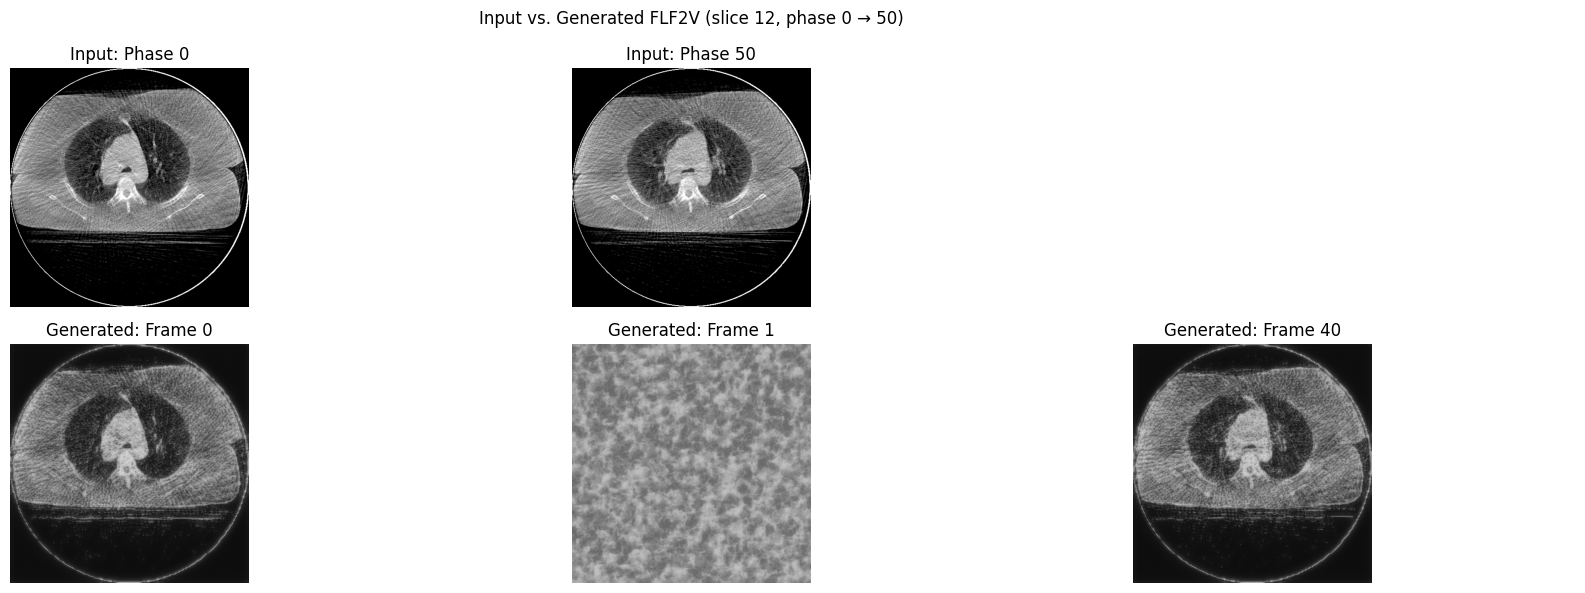

In [11]:
def unnormalize(image, window_min=WINDOW_MIN, window_max=WINDOW_MAX):
    """Convert normalized [-1, 1] image back to original HU scale."""
    return ((image + 1) / 2) * (window_max - window_min) + window_min

# Unnormalize generated video for HU visualization
gen_np = generated_video.cpu().numpy()[0,0]         # [T, H, W]
gen_np_vis = unnormalize(gen_np)

# Print min/max for diagnostic
print("Input phase 0: min/max =", phase_0.min(), phase_0.max())
print("Input phase 50: min/max =", phase_50.min(), phase_50.max())
print("Generated frame 0: min/max =", gen_np_vis[0].min(), gen_np_vis[0].max())
print("Generated frame 20: min/max =", gen_np_vis[1].min(), gen_np_vis[1].max())
print("Generated frame 40: min/max =", gen_np_vis[40].min(), gen_np_vis[40].max())

# --- Visualization: Input (phase 0, 50) + Generated (0, mid, 40) ---

plt.figure(figsize=(18, 6))

# Input: phase 0 (original scale)
plt.subplot(2, 3, 1)
plt.imshow(phase_0, cmap='gray', vmin=WINDOW_MIN, vmax=WINDOW_MAX)
plt.title("Input: Phase 0")
plt.axis("off")

# Input: phase 50 (original scale)
plt.subplot(2, 3, 2)
plt.imshow(phase_50, cmap='gray', vmin=WINDOW_MIN, vmax=WINDOW_MAX)
plt.title("Input: Phase 50")
plt.axis("off")

# Empty plot for spacing
plt.subplot(2, 3, 3)
plt.axis("off")

# Generated: frame 0 (unnormalized)
plt.subplot(2, 3, 4)
plt.imshow(gen_np_vis[0], cmap='gray', vmin=WINDOW_MIN, vmax=WINDOW_MAX)
plt.title("Generated: Frame 0")
plt.axis("off")

# Generated: mid-frame (unnormalized)
mid_idx = 1 #gen_np_vis.shape[0] // 2
plt.subplot(2, 3, 5)
plt.imshow(gen_np_vis[mid_idx], cmap='gray', vmin=WINDOW_MIN, vmax=WINDOW_MAX)
plt.title(f"Generated: Frame {mid_idx}")
plt.axis("off")

# Generated: last frame (unnormalized)
plt.subplot(2, 3, 6)
plt.imshow(gen_np_vis[-1], cmap='gray', vmin=WINDOW_MIN, vmax=WINDOW_MAX)
plt.title(f"Generated: Frame {gen_np_vis.shape[0]-1}")
plt.axis("off")

plt.suptitle("Input vs. Generated FLF2V (slice 12, phase 0 → 50)")
plt.tight_layout()
plt.show()


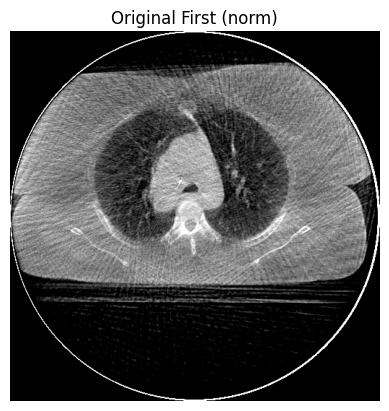

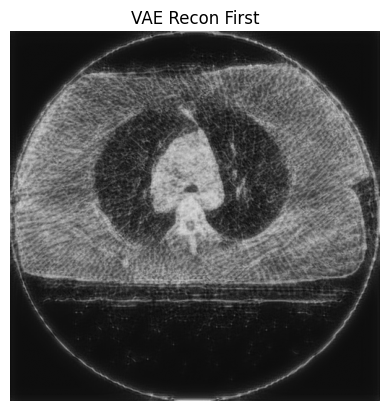

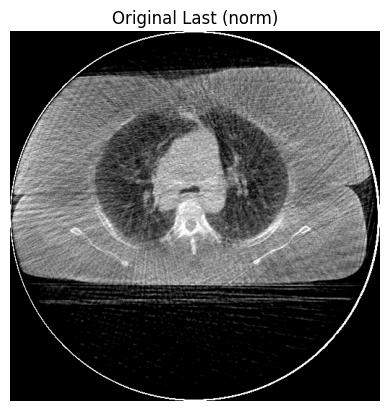

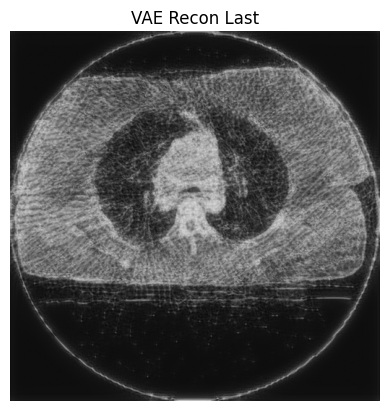

In [12]:
# Ensure model is on the correct device
vae = model.vae
vae.eval()
device = next(vae.parameters()).device

# Add time dimension: [B, C, T, H, W]
first5 = first.to(device).unsqueeze(2)   # [1, 1, 1, 512, 512]
last5  = last.to(device).unsqueeze(2)

with torch.no_grad():
    enc_f = vae.encode(first5)         # dict with keys: 'latent', 'z1', 'mu', ...
    z_f   = enc_f['latent']            # [1, latent_channels, 1, 128, 128]
    x_f_rec = vae.decode(z_f)          # [1, 1, 1, 512, 512]

    enc_l = vae.encode(last5)
    z_l   = enc_l['latent']
    x_l_rec = vae.decode(z_l)

import matplotlib.pyplot as plt

def show(img, title, vmin=-1, vmax=1):
    plt.figure()
    # For [1, 1, 1, H, W], squeeze all singleton dims except (H, W)
    plt.imshow(img.squeeze().cpu(), cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis('off')

# Display all 4 for visual comparison
show(first5, "Original First (norm)", vmin=-1, vmax=1)
show(x_f_rec, "VAE Recon First", vmin=-1, vmax=1)
show(last5, "Original Last (norm)", vmin=-1, vmax=1)
show(x_l_rec, "VAE Recon Last", vmin=-1, vmax=1)


In [8]:
sd = checkpoint['model_state_dict']
missing, unexpected = model.load_state_dict(sd, strict=False)
print("missing:", missing)
print("unexpected:", unexpected)

# check one critical layer
print("dit out_conv weight std =",
      model.dit.out_conv.weight.std().item())


missing: []
unexpected: []


AttributeError: 'LungCTDiT' object has no attribute 'out_conv'

In [20]:
with torch.no_grad():
    latent_vid = model.generate(first, last, num_frames=41, decode=False)
    print(latent_vid.shape, latent_vid.mean().item(), latent_vid.std().item())


🎬 Generating 41 frames
   Input shapes: first=torch.Size([1, 1, 1, 512, 512]), last=torch.Size([1, 1, 1, 512, 512])
   Latent shapes: first=torch.Size([1, 6, 1, 128, 128]), last=torch.Size([1, 6, 1, 128, 128])


Sampling:   0%|          | 0/20 [00:00<?, ?it/s]/home/ubuntu/flowmotion/src/flf2v/lungct_flow_matching.py:211: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
Sampling: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


✅ Sampling completed. Final shape: torch.Size([1, 6, 41, 128, 128])
   Generated latent: torch.Size([1, 6, 41, 128, 128])
torch.Size([1, 6, 41, 128, 128]) 0.0004286315233912319 1.0770270824432373


In [21]:
fm = model.flow_matching
fm.config.use_ode_solver = 'rk4'
fm.config.num_sampling_steps = 60   # training cfg says 20, so go 3×
generated = model.generate(first, last, num_frames=41, decode=True)


🎬 Generating 41 frames
   Input shapes: first=torch.Size([1, 1, 1, 512, 512]), last=torch.Size([1, 1, 1, 512, 512])
   Latent shapes: first=torch.Size([1, 6, 1, 128, 128]), last=torch.Size([1, 6, 1, 128, 128])


Sampling: 100%|██████████| 60/60 [00:28<00:00,  2.14it/s]


✅ Sampling completed. Final shape: torch.Size([1, 6, 41, 128, 128])
   Generated latent: torch.Size([1, 6, 41, 128, 128])


OutOfMemoryError: CUDA out of memory. Tried to allocate 41.00 GiB. GPU 0 has a total capacity of 39.49 GiB of which 30.24 GiB is free. Including non-PyTorch memory, this process has 9.25 GiB memory in use. Of the allocated memory 7.09 GiB is allocated by PyTorch, and 1.66 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)